In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import sys

In [2]:
files = ('./data/ising-8-12',
         './data/bc-crit-8-21',
         './data/tricritical-7-29')
names = ('Ising Limit',
        '2nd Order Critical Point',
        'Tricritical Point')
expected = (1.75,
           1.75,
           1.85)

In [3]:
def combined_error(group, field, se_field):
        N = len(group)
        s = group[field].std()
        sigma_i = group[se_field]
        # combine in quadrature
        total_error = np.sqrt((s**2) / N + (sigma_i**2).sum() / (N**2))
        # total_error = s / np.sqrt(N)
        return pd.Series({
            "mean": group[field].mean(),
            "std": s,
            "mean_se": sigma_i.mean(),
            "error": total_error
    })

In [10]:
# Magnet Susceptibility
def getSusceptibility(filename):
    df_raw = pd.read_csv(filename, sep=',')
    df = df_raw.groupby("L").apply(lambda x: combined_error(x, "magnetic_susceptibility", "standard_error")).reset_index()                      
        
    df['logL'] = np.log(df['L'])
    df['1/L'] = 1/df['L']
    df['logX'] = np.log(df['mean'])
    df['SE_logX'] = df['error'] / df['mean']

    n = df.shape[0]-2
    m = 0
    invL = np.zeros(n-m)
    gamma = np.zeros(n-m)
    error = np.zeros(n-m)

    for i in range(m,n):
        invL[i-m] = df['1/L'].iloc[i]
        gamma[i-m] = (df['logX'].iloc[i+2] - df['logX'].iloc[i]) / (df['logL'].iloc[i+2] - df['logL'].iloc[i])
        error[i-m] = np.sqrt((df['SE_logX'].iloc[i+2])**2 + (df['SE_logX'].iloc[i])**2) / (df['logL'].iloc[i+2] - df['logL'].iloc[i])
    return (invL, gamma, error)

In [11]:
def getB(filename):
    df_raw = pd.read_csv(filename, sep=',')
    df = df_raw.groupby("L").apply(lambda x: combined_error(x, "Corner_Contribution", "Error")).reset_index()
    
    df['logL'] = np.log(df['L'])
    df['1/L'] = 1/df['L']

    n = df.shape[0]-2
    m = 1
    invL = np.zeros(n-m)
    b = np.zeros(n-m)
    error = np.zeros(n-m)

    for i in range(m,n):
        invL[i-m] = df['1/L'].iloc[i]
        b[i-m] = (df['mean'].iloc[i+2] - df['mean'].iloc[i]) / (df['logL'].iloc[i+2] - df['logL'].iloc[i])
        error[i-m] = np.sqrt((df['error'].iloc[i+2])**2 + (df['error'].iloc[i])**2) / (df['logL'].iloc[i+2] - df['logL'].iloc[i])
    return (invL, b, error)

In [6]:
def plotFss(ax, invL, observable, error, observable_name, dataset_name, expected, 
            colors=('lightgray', 'dimgray', 'black'), name=''):
    maxheight = max(observable) * 1.2
    minheight = min(observable) * 0.8
    fit, cov = np.polyfit(invL, observable, 1, w=1/error, cov=True)
    yerr = cov[0][0]
    x = np.linspace(0, 1/6, 100)
    y = np.polyval(fit, x)
    
    # Axes
    ax.vlines((0,), minheight, maxheight, linestyle='solid', color=colors[0])
    ax.hlines((expected,), 0, 1/6, linestyle='solid', color=colors[0], label=f'Expected Answer {name}')

    ax.plot(x, y, linestyle='dashed', linewidth=1, color=colors[2])
    ax.errorbar(invL, observable, yerr=error, linestyle='none', fmt='.', capsize=3, color=colors[2])

    # Final ans
    ax.errorbar([0], [y[0]], [yerr], marker='D', markersize=3, capsize=3, color=colors[1], linestyle='none', label=f'Numerical Answer {name}')

    ax.set_ylim(minheight, maxheight)
    ax.set_title(f'{dataset_name}\n{observable_name} = {round(y[0], 5)} {r'$\pm$'} {round(yerr, 5)}') 
    ax.legend(loc='lower right')
    
    return (y[0], yerr)

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(6, 10))
plt.subplots_adjust(hspace=0.5)
for i in range(3):
    invL, gamma, error = getSusceptibility(files[i] + '/magnet.txt')
    plotFss(axs[i], invL, gamma, error, r'$\gamma/\nu$', names[i], expected[i])

fig.suptitle(f'FSS of {r'$\gamma/\nu$'}')
fig.supylabel(f'2-point estimate of {r'$\gamma/\nu$'}')
fig.supxlabel('1/L')
plt.show()

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(6, 10))
plt.subplots_adjust(hspace=0.5)
for i in range(3):
    invL, b, error = getB(files[i] + '/gap/fk.txt')
    plotFss(axs[i], invL, b, error, 'b', names[i])
    invL, b, error = getB(files[i] + '/gap/spin.txt')
    plotFss(axs[i], invL, b, error, 'b', names[i])

fig.suptitle(f'FSS of b')
fig.supylabel(f'2-point estimate of b')
fig.supxlabel('1/L')
plt.show()

/tmp/ipykernel_2336292/3479339240.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df_raw.groupby("L").apply(combined_error).reset_index()


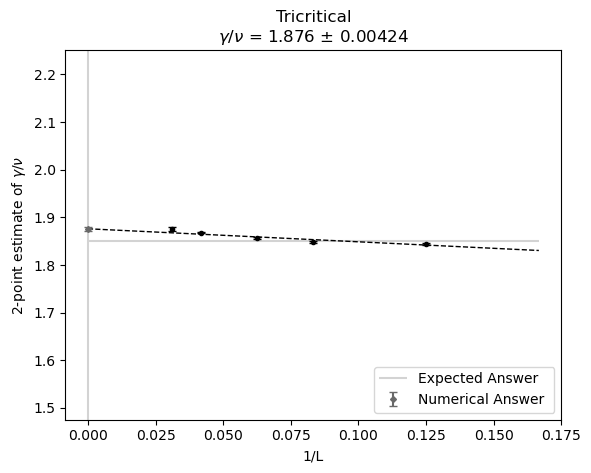

In [67]:
invL, gamma, error = getSusceptibility('./data/tc-10-8/magnet.txt')
plotFss(plt.gca(), invL, gamma, error, r'$\gamma/\nu$', 'Tricritical', 1.85)

# plt.title(f'FSS of {r'$\gamma/\nu$'}')
plt.ylabel(f'2-point estimate of {r'$\gamma/\nu$'}')
plt.xlabel('1/L')
plt.show()

/tmp/ipykernel_934773/2778907452.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df_raw.groupby("L").apply(lambda x: combined_error(x, "Corner_Contribution", "Error")).reset_index()
/tmp/ipykernel_934773/2778907452.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df_raw.groupby("L").apply(lambda x: combined_error(x, "Corner_Contribution", "Error")).reset_index()


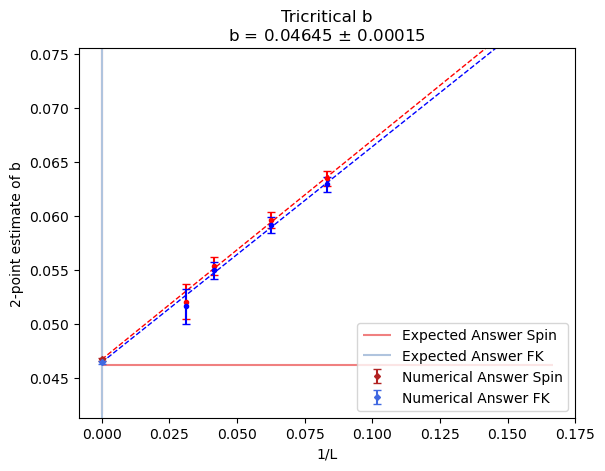

In [12]:
invL, b, error = getB('./data/tc-10-8/gap/spin.txt')
plotFss(plt.gca(), invL, b, error, 'b', 'Tricritical b', 0.739320704/16,
        colors=('lightcoral', 'firebrick', 'red'), name='Spin')
invL, b, error = getB('./data/tc-10-8/gap/fk.txt')
plotFss(plt.gca(), invL, b, error, 'b', 'Tricritical b', 0.343774677/16, 
        colors=('lightsteelblue', 'royalblue', 'blue'), name='FK')

# plt.title(f'FSS of {r'$\gamma/\nu$'}')
plt.ylabel(f'2-point estimate of b')
plt.xlabel('1/L')
plt.show()

In [23]:
def getFit(invL, observable, error):
    maxheight = max(observable) * 1.2
    minheight = min(observable) * 0.8
    fit, cov = np.polyfit(invL, observable, 1, w=1/error, cov=True)
    yerr = cov[0][0]
    x = np.linspace(0, 1/6, 100)
    y = np.polyval(fit, x)
    
    return y[0]

def getSusceptibility(group):
    group['logL'] = np.log(group['L'])
    group['1/L'] = 1/group['L']
    group['logX'] = np.log(group['magnetic_susceptibility'])
    group['SE_logX'] = group['standard_error'] / group['magnetic_susceptibility']
    
    n = group.shape[0]-2
    m = 0
    invL = np.zeros(n-m)
    gamma = np.zeros(n-m)
    error = np.zeros(n-m)

    for i in range(m,n):
        invL[i-m] = group['1/L'].iloc[i]
        gamma[i-m] = (group['logX'].iloc[i+2] - group['logX'].iloc[i]) / (group['logL'].iloc[i+2] - group['logL'].iloc[i])
        error[i-m] = np.sqrt((group['SE_logX'].iloc[i+2])**2 + (group['SE_logX'].iloc[i])**2) / (group['logL'].iloc[i+2] - group['logL'].iloc[i])

    return pd.Series({
            "fit": getFit(invL, gamma, error)
    })

def mass(filename):
    df_raw = pd.read_csv(filename, sep=',')
    df = df_raw.groupby("batch").apply(getSusceptibility).reset_index()                      
    return (df['fit'].mean(), df['fit'].std())
    

In [24]:
print(mass('./data/tc-10-8/magnet.txt'))

   batch       fit
0      0  1.867315
1      1  1.881452
2      2  1.867498
3      3  1.873533
4      4  1.873441
5      5  1.877118
6      6  1.878466
7      7  1.879553
8      8  1.876229
9      9  1.881541


/tmp/ipykernel_934773/3428955869.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df_raw.groupby("batch").apply(getSusceptibility).reset_index()
